TODO:
1. Test if having linear activation for output layer on the deceptor will cause it to "cheat"
2. Test different activation functions for output layer on the deceptor

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pprint
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images, test_images = train_images / 256, test_images / 256

In [3]:
deceptor = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(28, input_shape=(28, 28), activation=tf.keras.activations.tanh)
])
#deceptor.compile()
deceptor.build((28, 28))
print(deceptor.layers[0].input_shape)

(28, 28)


In [4]:
classifier = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
classifier.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
print(classifier.layers[0].input_shape)
print(classifier.summary())

(None, 28, 28)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
classifier_optimizer = tf.keras.optimizers.Adam(1e-4)
deceptor_optimizer = tf.keras.optimizers.Adam(1e-4)
classifier_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
# def deceptor_loss(classifierLoss):
#     return 1/classifierLoss


def deceptor_loss(original_loss, modified_loss):
    return 1/(modified_loss - original_loss)

@tf.function
def train_step(images, labels, noise_weight=0.1):
#    print(labels)
    start_time=time.perf_counter()
    with tf.GradientTape() as cls_tape, tf.GradientTape() as dcp_tape:
        cls_tape.watch(classifier.variables)
        dcp_tape.watch(deceptor.variables)
        #Real Prediction
        real_prediction = classifier(tf.expand_dims(images, 0), training=True)
        
        #Fake Prediction
        noise_profile = tf.cast(deceptor(images, training=True), dtype=tf.float64)
        images = tf.math.add(tf.convert_to_tensor(images) * 1-noise_weight, noise_profile * noise_weight)
        images.set_shape((28, 28))
        fake_prediction = classifier(tf.expand_dims(images, 0), training=True)

        #Calculae Loss
        real_loss = classifier_loss(labels, real_prediction)
        fake_loss = classifier_loss(labels, fake_prediction)
        dcp_loss = deceptor_loss(fake_loss, real_loss)

    #Calculate Gradients
    gradients_of_classifier = cls_tape.gradient(fake_loss, classifier.trainable_variables)
    gradients_of_deceptor = dcp_tape.gradient(dcp_loss, deceptor.trainable_variables)
    
    #Apply Gradients
    classifier_optimizer.apply_gradients(zip(gradients_of_classifier, classifier.trainable_variables))
    deceptor_optimizer.apply_gradients(zip(gradients_of_deceptor, deceptor.trainable_variables))
    end_time = time.perf_counter()
    total_time = end_time-start_time
    print(f"Step time: {total_time} Classifier loss: {fake_loss} Deceptor loss: {dcp_loss}", end="\r")
    return [fake_loss, dcp_loss]
def train(images, labels, epochs, noise_weight=0.1):
    assert noise_weight <= 1.0
    losses = []
    for epoch in range(epochs):
        for i, (image_batch, label_batch) in enumerate(zip(images, labels)):
            print(f"Image: {i}", end="\r")
            step_loss = train_step(image_batch, label_batch)
            losses.append(step_loss)
        print(f"Finished epoch {epoch}")
    losses = np.asarray(losses)
    return np.transpose(losses)

In [11]:
history = train(train_images, train_labels, 1, noise_weight=0.0)

Finished epoch 0


In [61]:
array = np.array([
    [
    [111, 112, 113],
    [121, 122, 123],
    [131, 132, 133]
    ],[
    [211, 212, 213],
    [221, 222, 223],
    [231, 232, 233],
    ],[
    [311, 312, 313],
    [321, 322, 323],
    [331, 332, 333]
    ]])
print(np.moveaxis(array, 0, 2))

[[[111 211 311]
  [112 212 312]
  [113 213 313]]

 [[121 221 321]
  [122 222 322]
  [123 223 323]]

 [[131 231 331]
  [132 232 332]
  [133 233 333]]]


In [ ]:
image1 = train_images[0]
image2 = train_images[1]

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape((28, 28))
])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.predict([np.expand_dims(image1, 0)])

In [ ]:
pprint.pprint(classifier.layers[0].__dict__)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
#print(model(train_images[0]))
#model.fit(train_images, train_labels)
model.predict(np.expand_dims(train_images[0], 0))

In [ ]:
model.predict(np.expand_dims(train_images[0], 1))

In [ ]:
tf.version.VERSION

In [8]:
print(classifier(train_images[0]))

NameError: name 'classifier' is not defined

In [16]:
test_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Reshape((4, 4))
    ])
print(test_model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 16)                12560     
                                                                 
 reshape_3 (Reshape)         (None, 4, 4)              0         
                                                                 
Total params: 12,560
Trainable params: 12,560
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
print(classifier(train_images[0]))

ValueError: Exception encountered when calling layer "sequential_10" (type Sequential).

Input 0 of layer "dense_16" is incompatible with the layer: expected axis -1 of input shape to have value 784, but received input with shape (28, 28)

Call arguments received:
  • inputs=tf.Tensor(shape=(28, 28), dtype=float64)
  • training=None
  • mask=None

In [26]:
classifier.fit(train_images, train_labels)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4992


In [26]:
classifier(np.expand_dims(train_images[0], 0), training=True)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-8.529167  , -7.4230576 , -4.8804407 , -6.8092594 , -3.7742395 ,
        -0.21548933, -4.7232656 , -1.9982957 , -0.17475839,  3.6250157 ]],
      dtype=float32)>

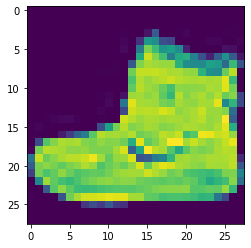

In [27]:
plt.imshow(train_images[0])

In [14]:
classifier.evaluate(train_images, train_labels)

1875/1875 [==============================] - 2s 1ms/step - loss: 1.2938


1.293799638748169

In [40]:
classifier_cringe = classifier

In [23]:
noise = deceptor(train_images[0], training=True)
print(tf.math.argmax(noise))

tf.Tensor(
[ 0 19 19  0  0  0  0  0  0  0 19 20 20 19 19 19 20 19 19  0  0  0  0  0
  0 19 19 20], shape=(28,), dtype=int64)


In [12]:
print(classifier(np.expand_dims(train_images[0], 0)))

tf.Tensor(
[[-11.353879    -9.620456    -4.7171264   -9.845136    -6.6923976
    5.506843    -4.689149     1.0812107   -0.03498985   5.60465   ]], shape=(1, 10), dtype=float32)


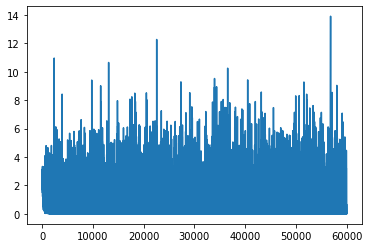

In [10]:
mpl.pyplot.plot(history[0])

In [ ]:
print(history.shape)

In [22]:
print(len(history))

600000


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]


In [8]:
classifier(tf.expand_dims(train_images[0], 0), training=True)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ -6.79064  , -11.358002 ,  -9.37481  , -10.515266 , -10.2645035,
          1.8145442,  -9.424309 ,   0.6083254,   0.3639837,   7.379331 ]],
      dtype=float32)>

In [32]:
classifier.evaluate(test_images, test_labels)

313/313 [==============================] - 4s 6ms/step - loss: nan


nan